<strong>为什么要深度学习?</strong><br>
废话不多,直接上图<br>
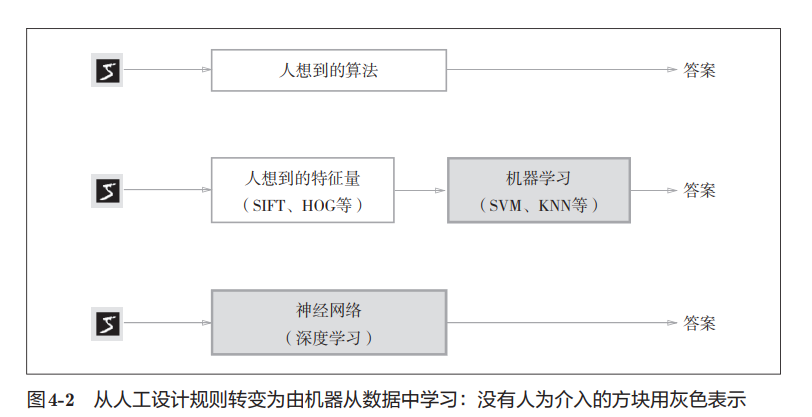

深度学习彻底解放了人思考的步骤,直接靠强大的算力去学习

In [1]:
# 进行数据集读入

import cv2
import numpy as np
import pickle
from mnist import load_mnist
import neuralnet_mnist as ne # 导入之前写好的框架

# 为了下面的损失函数的理解及应用,转换label为one_hot模式
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = True,one_hot_label = True)
t = t_test[0]
print(t)

# 获取神经网络
network = ne.init_network()

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### 损失函数的引入

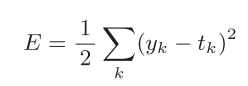<strong>均方误差</strong>

In [2]:
# 均方误差函数
def mean_squared_error(y,t):
    return 0.5*np.sum((y-t)**2)

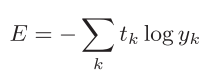<strong>交叉熵误差</strong>  
其中log为ln,即自然对数

In [3]:
# 交叉熵误差函数
def corss_entropy_error(y,t):
    p = 1e-7
    return -np.sum(t*np.log(y+p)) # 加上偏移量,防止ln0返回-INF,错误

**mini-batch学习**,即处理样本的损失函数即可,不计算全部.  
以交叉熵为例,求得单个输入层的平均损失值公式:<br>
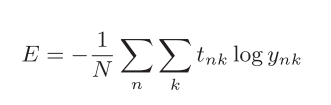

In [4]:
#先随机选取100个训练数据

print(x_train.shape)
x_train_size = x_train.shape[0] # 先获取总体数
batch_size = 10  # 设置想要处理的样本数
batch_mask = np.random.choice(x_train_size,batch_size)

print(batch_mask) # 得到的是数组下标

# 利用numpy获取对应的100个数据
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


(60000, 784)
[37823 35544 33794   218 40201 23225 51333 29577 30515 47546]


In [5]:
# mini_batch版交叉熵的实现:基于one_hot格式的label
def cross_entropy_error1(y,t):
    # 为保证泛用性,对一维数组进行reshape为二维
    if y.ndim == 1:
        y = y.reshape(1,-1)
        t = t.reshape(1,-1)
    
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y + 1e-7))/batch_size

y = ne.forword(network,x_batch)[1] # 获取绝对概率输出批层
ans1 = cross_entropy_error1(y,t_batch)
print(t_batch)
print(ans1) # 输出损失函数值

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
0.07620148351415992


In [6]:
# 重新读入数据集,这次用非one_hot形式
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = True,one_hot_label = False)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
print(batch_mask)

#(我的)mini_batch版交叉熵的实现:非one_hot格式的label
def my_cross_entropy_error(y,t):
    if y.ndim == 1:
        y = y.reshape(1,-1)
        t = t.reshape(1,-1)
    batch_size = y.shape[0]

    #观察发现仅有正确的位置t的one_hot形式才会有贡献
    sum = 0
    for i in range(batch_size):
        sum += np.log(y[i][t[i]] + 1e-7)
    return -sum/batch_size

print(t_batch)
ans2 = my_cross_entropy_error(y,t_batch)
print(ans2)

#符合预期,one_hot与非one_hot在同一mask下损失值一样

[37823 35544 33794   218 40201 23225 51333 29577 30515 47546]
[5 7 6 6 1 3 3 4 3 8]
0.07620148


In [7]:
#mini_batch版交叉熵的实现(简化,矩阵加速运算):非one_hot格式的label
def cross_entropy_error2(y,t):
    if y.ndim == 1:
        y = y.reshape(1,-1)
        t = t.reshape(1,-1)
    batch_size = y.shape[0]

    # 巧妙的numpy运用,利用矩阵加快运算
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

print(t_batch)
ans3 = cross_entropy_error2(y,t_batch)
print(ans3)

# 与我的函数结果一致,但是这个理论上更快

[5 7 6 6 1 3 3 4 3 8]
0.07620148


**上面的三种结果输出的损失值一致**

In [9]:
t = t_test[0]
x = x_test[0]
loss = cross_entropy_error2(x,t)
print(loss)

16.118095
